In [1]:
import numpy as np
import scipy.stats as ss
import elfi
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
import pyabc
from pyabc.examples import clinic
from pyabc.plots import plot_marginals
%matplotlib notebook

warning in stationary: failed to import cython module: falling back to numpy


# Clinic Example
![](img/clinic.png)

In [2]:
simulator = clinic.simulator

In [3]:
# Set the generating parameters that we will try to infer
lambda0 = 1/10

# Generate some dat9 (using a fixed seed here)
np.random.seed(1228)
y0 = simulator(lambda0)
print(y0)

[[49], array([  0.        ,   0.        ,   0.        ,   0.        ,
         0.42344354,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   4.51585521,   0.        ,
         4.34929369,   5.33611555,   4.79045358,  11.19269357,
        10.47966238,   6.52416327,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   5.97595535,   8.83547883,
         0.        ,   0.        ,   0.        ,   0.29101362,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,   0.        ]), [964.8378133280579]]


In [4]:
closing_time, nr_patients, nr_waiting_patients = clinic.summaries

In [5]:
# prior over rate parameter
rate = pyabc.Prior('uniform', 0.01,1, name='rate')
rate.name

'rate'

# Our PYABC

In [6]:
rej = pyabc.RejectionSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [7]:
rej.sample(nr_samples=1000, threshold=0.01)

Rejection sampler started with threshold: 0.01 and number of samples: 1000
Samples:   1000 - Threshold: 0.01 - Iterations:      25000 - Acceptance rate: 0.040000 - Time:    28.78 s


In [8]:
smc = pyabc.SMCSampler(priors=[rate], simulator=simulator, 
                             summaries=[closing_time, nr_patients, nr_waiting_patients],
                             observation=y0)

In [9]:
smc.sample(nr_samples=1000, thresholds=[0.1, 0.05, 0.01])

SMC sampler started with thresholds: [0.1, 0.05, 0.01] and number of samples: 1000
Rejection sampler started with threshold: 0.1 and number of samples: 1000
Iteration 0 completed
starting iteration[ 1 ]
Iteration 1 completed
starting iteration[ 2 ]
Iteration 2 completed
Samples:   1000 - Thresholds: 0.01 - Iterations:      12837 - Acceptance rate: 0.077900 - Time:    11.80 s


<IPython.core.display.Javascript object>


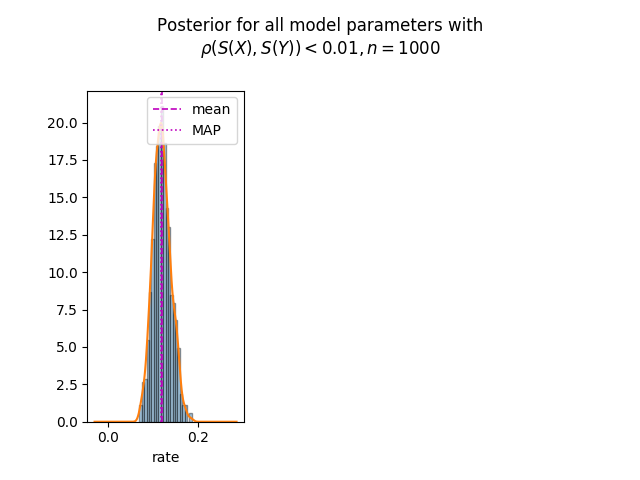

<IPython.core.display.Javascript object>


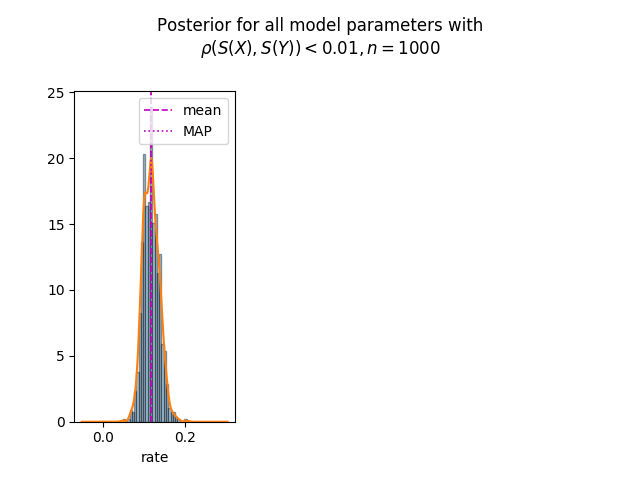

In [10]:
plot_marginals(rej, kde=True)
plot_marginals(smc, kde=True)

<IPython.core.display.Javascript object>


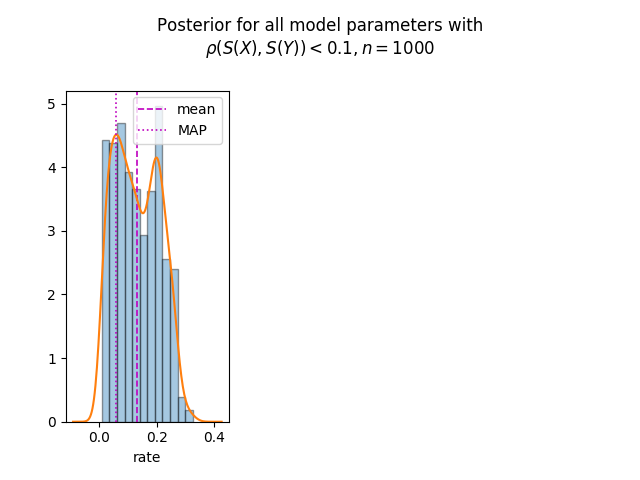

<IPython.core.display.Javascript object>


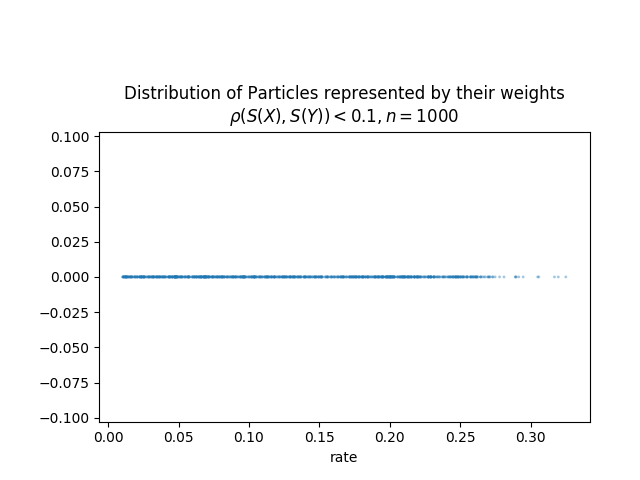

<IPython.core.display.Javascript object>


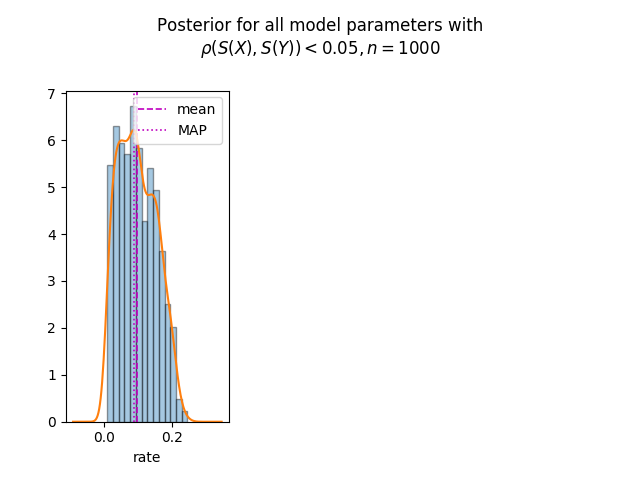

<IPython.core.display.Javascript object>


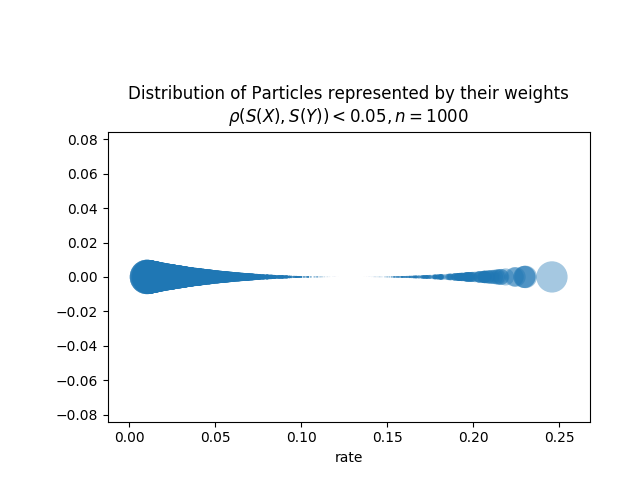

<IPython.core.display.Javascript object>


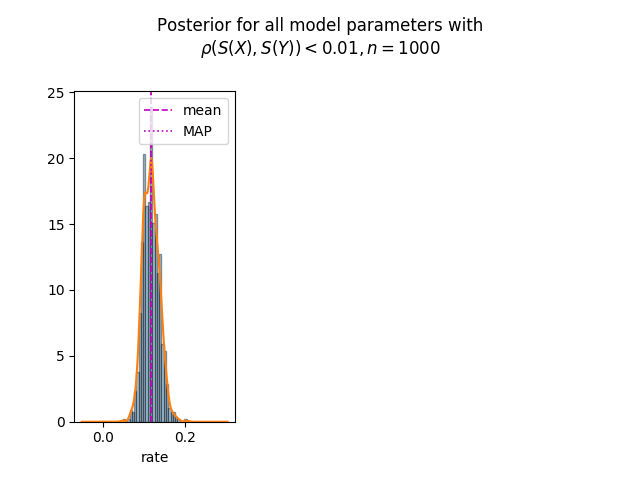

<IPython.core.display.Javascript object>


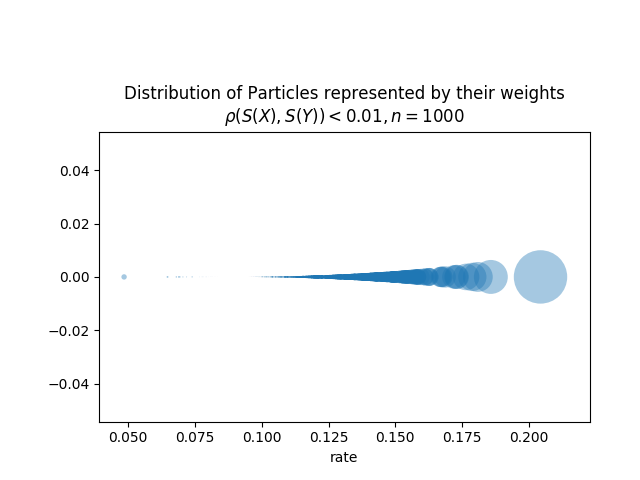

In [11]:
plot_marginals(smc, plot_particles=True, kde=True)

<IPython.core.display.Javascript object>


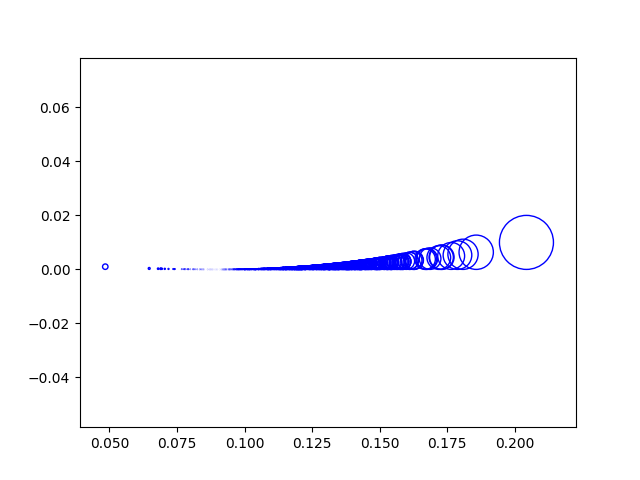

(0.039082624875127141, 0.22273026844815555, -0.001, 0.021000000000000001)

In [12]:
plt.figure()

weights = smc.weights[-1]
yy= (weights - weights.min()) / (weights.max() - weights.min()) / 100
xx= smc.Thetas

for x,y in zip(xx, yy):
    c = plt.Circle((x,y), radius=y, edgecolor="b", facecolor="none")
    plt.gca().add_patch(c)

plt.xlim([xx.min(), xx.max()])
plt.axis("equal")


In [14]:
smc.weights[-1].reshape(-1,1)[abs(smc.Thetas - 0.1) < 0.05].mean()

0.00098860391059703485

<IPython.core.display.Javascript object>


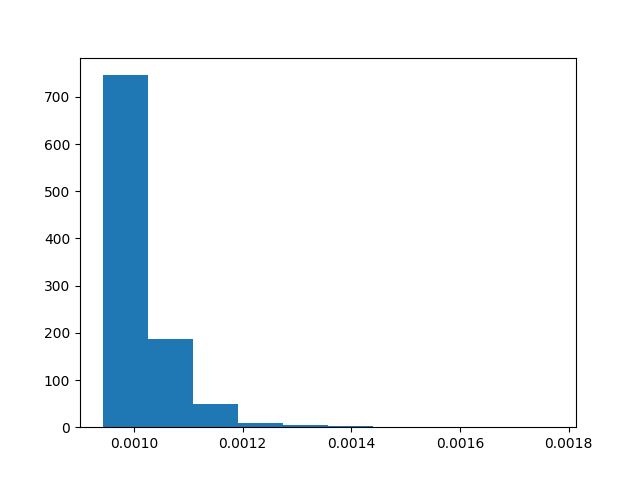

In [15]:
plt.figure()
plt.hist(smc.weights[-1])
plt.show()